# Test on Global scale# 

In [1]:
%matplotlib notebook
%env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns
%env GOOGLE_APPLICATION_CREDENTIALS /home/ag7531/access_key.json

import mlflow
from mlflow.tracking import client
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib
import matplotlib.pyplot as plt
from analysis.utils import (select_experiment, select_run, plot_dataset, GlobalPlotter, anomalies,
                            download_data_pred, plot_time_series)
from data.pangeo_catalog import get_whole_data
from data.xrtransforms import SeasonalStdizer, TargetedTransform, ScalingTransform
from dask.diagnostics import ProgressBar
from models.submodels import transform3

import cartopy.crs as ccrs
import cmocean
cmap = cmocean.cm.balance
cmap_balance = cmocean.cm.balance
cmap_balance_r=cmocean.cm.balance_r
cmap_amp = cmocean.cm.amp
cmap_amp_r = cmocean.cm.amp_r

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

uv_plotter = GlobalPlotter() 
uv_plotter.x_ticks = np.arange(-150., 151., 50)
uv_plotter.y_ticks = np.arange(-80., 81., 20)
uv_plotter.margin = 10

client_ = client.MlflowClient()





env: MLFLOW_TRACKING_URI=/scratch/ag7531/mlruns
env: GOOGLE_APPLICATION_CREDENTIALS=/home/ag7531/access_key.json


This downloads some information about the grid, used latero on

In [2]:
CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'
data = get_whole_data(CATALOG_URL, 0)
grid_info = data[1]

In [22]:
grid_info['dxu']

<xarray.DataArray 'dxu' (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<xarray-dxu, shape=(2700, 3600), dtype=float64, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:  width of C_cell
    units:      m

In [3]:
exp_id, test_exp_name = select_experiment()
cols=['status', 'start_time', 'params.CO2', 'params.factor',
      'params.submodel']
merge=[('data-global', 'params.data_run_id', 'run_id'),
       ('meeting22july', 'params.model_run_id', 'run_id')]
run = select_run(experiment_ids=exp_id, cols=cols, merge=merge)
data, pred = download_data_pred(run['params.data_run_id'], run.run_id)

7 :  Unet
21 :  modelsv1
6 :  multiregion
3 :  multiregions
19 :  data-global
14 :  forcingdatav3
17 :  meeting22july
5 :  regionsfortraining
2 :  training
4 :  default
13 :  forcingdatav2
16 :  meeting15july
22 :  parameterized
20 :  test_global
9 :  forcingdata1pct
12 :  test
15 :  datacm21
8 :  arctan
18 :  forcing-data-global
Select the id of an experiment: 20
                             run_id experiment_id    status  \
0  311a3033d40f431da3cdf55e3ca9a6fe            20  FINISHED   
1  67b690490db04b6d8167f018941c7024            20  FINISHED   
2  e8b4e2d8cd534909a453f4bcda9701b1            20  FINISHED   

                        start_time params.CO2 params.factor params.submodel  
0 2020-11-19 20:25:48.795000+00:00          0             5            None  
1 2020-11-18 19:37:59.439000+00:00          0             4            None  
2 2020-11-17 22:20:05.237000+00:00          1             4            None  
Run id?1


In [4]:
from IPython.core.display import HTML
html = '<h2>Menu</h2>'
html += '<a href="#MSE-and-R²">MSE and R²</a> &nbsp;'
html += '<a href="#Correlation-between-true-forcing-and-mean-component-of-the-prediction"> Correlation</a> &nbsp;'
html += '<a href="#Variance-of-norm-of-subgrid-momentum-forcing">Variance of forcing</a>'
HTML(html)

In [ ]:
# OLD! Do not use anymore
data = xr.open_zarr(data_file_name)
data = data.rename({'xu_ocean': 'longitude', 'yu_ocean': 'latitude'})
pred_file_name = client_.download_artifacts(run.run_id, 'test_output_0')
pred = xr.open_zarr(pred_file_name)
pred = pred[['S_xpred', 'S_ypred', 'S_xscale', 'S_yscale']]
pred = pred.rename(dict(S_xpred='S_x', S_ypred='S_y'))

data = data.sel(time=slice(pred.time[0], pred.time[-1]))

# merged = xr.merge((data, pred))

In [8]:
t = SeasonalStdizer(std=True)
with ProgressBar():
    t.fit(data)

[                                        ] | 1% Completed |  8.1s


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


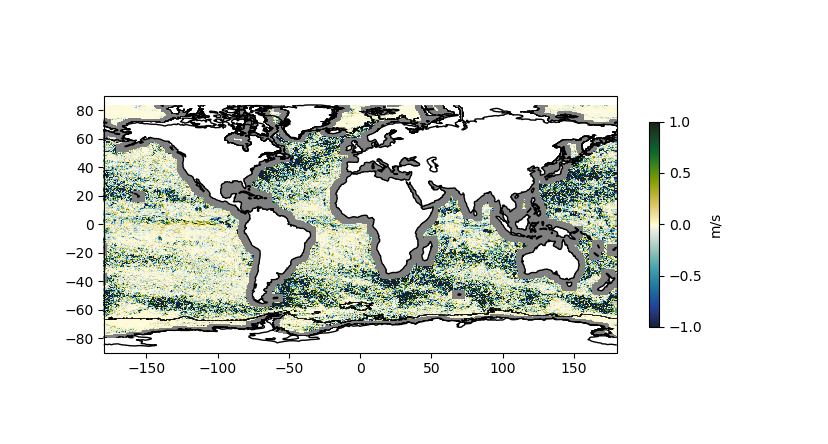

<GeoAxesSubplot:>

In [5]:
uv_plotter.plot(data['S_x'].isel(time=2000), lon=0., projection_cls = ccrs.PlateCarree,
                colorbar_label='m/s', cmap=cmocean.cm.delta, vmin=-1, vmax=1)

In [5]:
from dask.diagnostics import ProgressBar
seasonal_groupby = data.groupby('time.month')
seasonal_means = seasonal_groupby.mean()
with ProgressBar():
    seasonal_means = seasonal_means.compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[#                                       ] | 3% Completed | 14.7s


KeyboardInterrupt: 

In [6]:
time_slice=slice(500, 800)
plot_time_series(data, pred, longitude=-42, latitude=39, time=time_slice)

<IPython.core.display.Javascript object>

NameError: name 'data' is not defined

In [9]:
plt.savefig('timeseriespredcontrol.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## MSE and R²

First we compute the seasonal (monthly) means of the data. This will be used later in some of the metrics.

In [5]:
seasonal_means = data.groupby('time.month').mean()
with ProgressBar():
    seasonal_means = seasonal_means.compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[#                                       ] | 4% Completed | 16.8s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  6min  7.2s


In [7]:
error_S_X = pred['S_x'] - data['S_x']
error_S_Y = pred['S_y'] - data['S_y']
error_month_s_x = anomalies(data['S_x'])
error_month_s_y = anomalies(data['S_y'])

# Old version
#error_month_s_x = seasonal_means['S_x'] - data['S_x'].groupby('time.month')
#error_month_s_y = seasonal_means['S_y'] - data['S_y'].groupby('time.month')


Below, mse is the time-mean MSE of the mean component of our predicted forcing, mse_month is the variance of the residuals of the data after removing monthly variation.

In [8]:
component = 'Y'
if component == 'X':
    mse = (error_S_X**2).mean(dim='time')
    mse_month = (error_month_s_x**2).mean(dim='time')
    amplitudes = (data['S_x']**2).mean(dim='time')
elif component == 'Y':
    mse = (error_S_Y**2).mean(dim='time')
    mse_month = (error_month_s_y**2).mean(dim='time')
    amplitudes = (data['S_y']**2).mean(dim='time')
else:
    mse = (error_S_X**2 + error_S_Y**2).mean(dim='time')
    mse_month = (error_month_s_x**2 + error_month_s_y**2).mean(dim='time')
    amplitudes = (data['S_x']**2 + data['S_y']**2).mean(dim='time')

with ProgressBar():
    mse = mse.compute()
    mse_month = mse_month.compute()
    amplitudes = amplitudes.compute()
    

[########################################] | 100% Completed | 37.8s
[                                        ] | 0% Completed |  0.0s

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####                                    ] | 10% Completed |  4.3s

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 42.1s
[########################################] | 100% Completed | 24.5s


/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


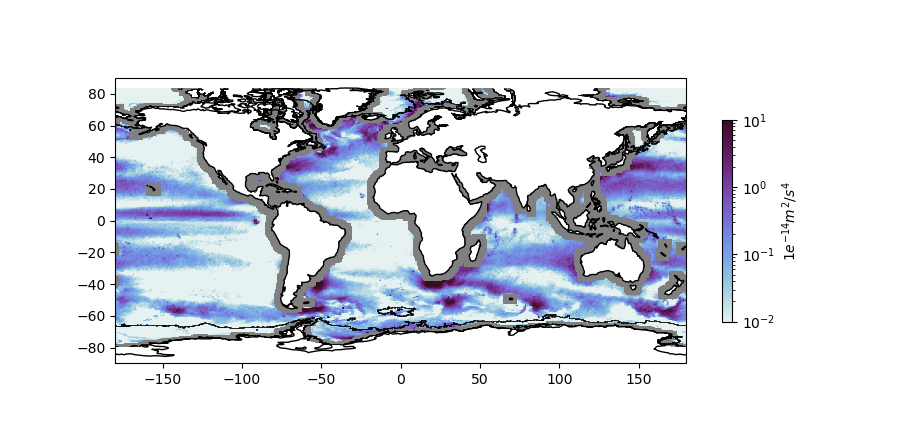

In [9]:
x = uv_plotter.plot(mse, vmin=0.01, vmax=10, lon=0., cmap=cmocean.cm.dense,
                    colorbar_label=r'$1e^{-14}m^2/s^4$', norm=matplotlib.colors.LogNorm())


In [16]:
plt.savefig('msecontrol_Y.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
plt.savefig('mse1pct.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


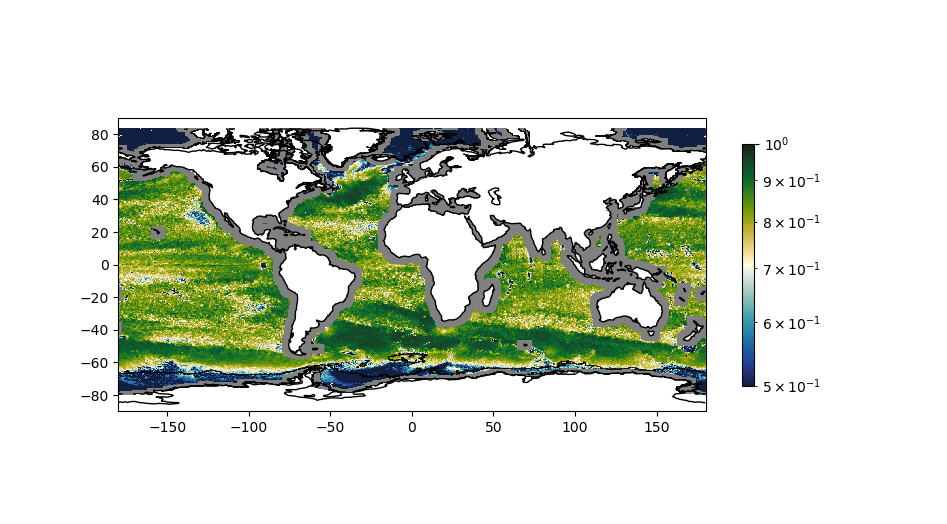

<GeoAxesSubplot:>

In [10]:
import matplotlib
rsquared = 1 - mse / amplitudes
rsquared_cycles = 1 - mse / mse_month
mse_ratio_2 = 1 - mse_month / amplitudes
uv_plotter.plot(rsquared_cycles, vmin=0.5, vmax=1, cmap=cmocean.cm.delta, lon=0., norm=matplotlib.colors.LogNorm())

In [18]:
plt.savefig('r2_control_month_y.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
plt.savefig('r2_1pctC02_month.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


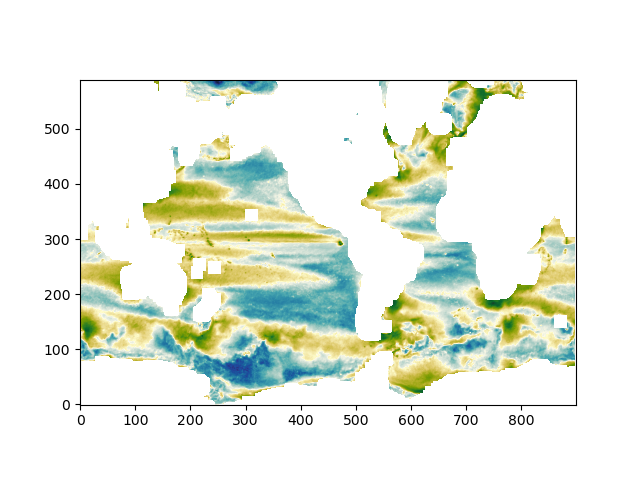

In [17]:
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array
mse = apply_complete_mask(mse)
mse_month = apply_complete_mask(mse_month)
amplitudes = apply_complete_mask(amplitudes)
plt.figure()
plt.imshow(np.log(mse), origin='lower', cmap=cmocean.cm.delta)

In [18]:
latitudes = slice(-60, 60)
with ProgressBar():
    mse_scalar = mse.sel(latitude=latitudes).mean().compute()
    mse_month_scalar = mse_month.sel(latitude=latitudes).mean().compute()
    amplitudes_scalar = amplitudes.sel(latitude=latitudes).mean().compute()
    rsquared_scalar_month = 1 - mse_scalar / mse_month_scalar
    rsquared_scalar = 1 - mse_scalar / amplitudes_scalar
print(rsquared_scalar)
print(rsquared_scalar_month)

<xarray.DataArray ()>
array(0.86495024)
<xarray.DataArray ()>
array(0.84935432)


In [19]:
rsquared_scalar_month

<xarray.DataArray ()>
array(0.84935432)

## Correlation between true forcing and mean component of the prediction 

In [11]:
data_anomaly = anomalies(data)
pred_anomaly = anomalies(pred)

In [14]:
std_data = np.sqrt((data_anomaly['S_x']**2).mean(dim='time'))
std_pred = np.sqrt((pred_anomaly['S_x']**2).mean(dim='time'))
corr_s_x = ((data_anomaly['S_x']* pred_anomaly['S_x']).mean(dim='time') - data_anomaly['S_x'].mean(dim='time') * pred_anomaly['S_x'].mean(dim='time')) / (std_data * std_pred)
# corr_s_y = xr.corr(data.S_y, pred.S_y, dim='time')

In [16]:
with ProgressBar():
    corr_s_x = corr_s_x.compute()
    # corr_s_y = corr_s_y.compute()

[###############                         ] | 38% Completed | 47.3s

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 48.2s


<IPython.core.display.Javascript object>


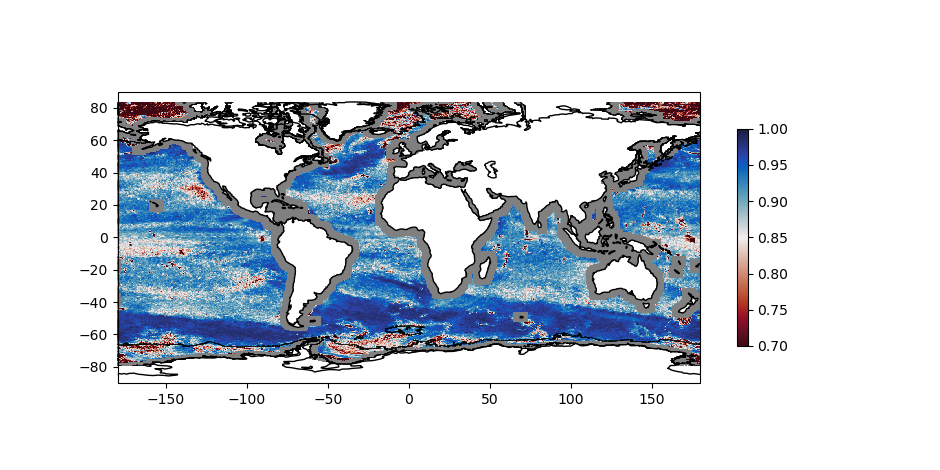

<GeoAxesSubplot:>

In [19]:
uv_plotter.plot(corr_s_x, vmin=0.7, vmax=1., lon=0., cmap=cmocean.cm.balance_r)

In [14]:
plt.savefig('corr_X_1pct.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
with ProgressBar():
    std_S_X = data_anomaly['S_x'].std(dim='time')
    std_S_X_pred = pred_anomaly['S_x'].std(dim='time')

    corr_S_X = (data_anomaly['S_x'] * pred_anomaly['S_x']).mean(dim='time') - data_anomaly['S_x'].mean('time') * pred_anomaly['S_x'].mean('time')
    corr_S_X = corr_S_X / (std_S_X * std_S_X_pred)
    corr_S_X = corr_S_X.compute()

[##############                          ] | 35% Completed |  2min 58.7s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  6min 50.4s


## Variance of norm of subgrid momentum forcing 

In [20]:
norm_S = np.sqrt(data['S_x']**2 + data['S_y']**2)
norm_Spred = np.sqrt(pred['S_x']**2 + pred['S_y']**2)
std_norm_S = norm_S.var(dim='time')
std_norm_Spred = norm_Spred.var(dim='time')
with ProgressBar():
    v1 = std_norm_S.compute()
    v2 = std_norm_Spred.compute()

[########################################] | 100% Completed |  1min  4.8s
[                                        ] | 0% Completed |  0.0s

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.1s


<IPython.core.display.Javascript object>


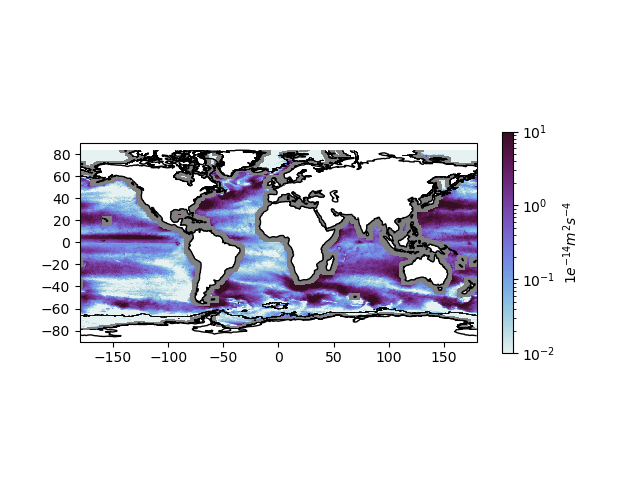

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [11]:
%matplotlib notebook
import matplotlib
cmap=cmocean.cm.amp
uv_plotter.plot(v2, vmin=0.01, vmax=10, cmap=cmocean.cm.dense, lon=0., colorbar_label=r'$1e^{-14}m^2s^{-4}$', norm=matplotlib.colors.LogNorm())

In [10]:
plt.savefig('variance_forcing_control.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
plt.savefig('variance_forcing_control_pred.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


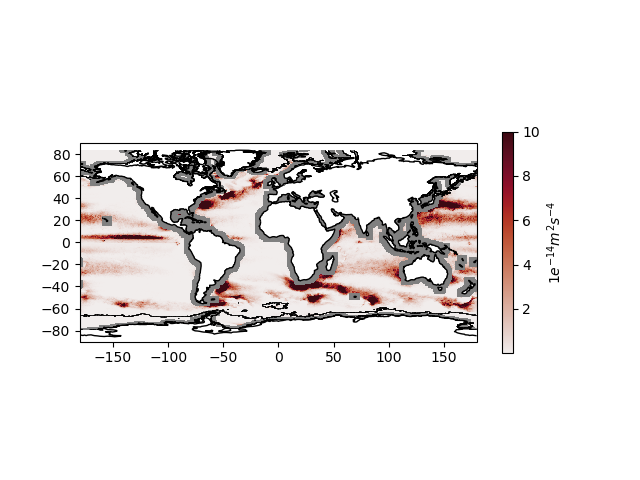

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [29]:
cmap=cmocean.cm.amp
uv_plotter.plot(v2, vmax=10, cmap=cmap, lon=0., colorbar_label=r'$1e^{-14}m^2s^{-4}$')

In [57]:
plt.savefig('variance_forcing_control_pred.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Compare distributions of true and mean predicted forcing

In [69]:
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array


pred_ = apply_complete_mask(pred)
data_ = apply_complete_mask(data)

# Subsample the data
time_slice = slice(None, 1000, 1)
lon_slice = slice(None, None, 1)
lat_slice = slice(-40, 40)
pred_ = pred_.sel(longitude=lon_slice, latitude=lat_slice).isel(time=time_slice)
data_ = data_.sel(longitude=lon_slice, latitude=lat_slice).isel(time=time_slice)

# Standardized residuals
residuals_x = (data_['S_x'] - pred_['S_x']) / pred_['S_xscale']
residuals_y = (data_['S_y'] - pred_['S_y']) / pred_['S_yscale']

Here we do a stochastic simulation of the forcing given the parameters of the Gaussian distribution at each location and each time point

In [10]:
shape = tuple(pred_.dims.values())
epsilons = dict(x=np.random.randn(*shape), y=np.random.randn(*shape))
epsilons = xr.Dataset(dict(S_x=(pred_.dims, epsilons['x']), S_y=(pred_.dims, epsilons['y'])))
pred_stochastic_x = pred_['S_x'] + pred_['S_xscale'] * epsilons['S_x']
pred_stochastic_y = pred_['S_y'] + pred_['S_yscale'] * epsilons['S_y']
pred_stochastic = xr.Dataset(dict(S_x=pred_stochastic_x, S_y=pred_stochastic_y),  coords=pred_.coords)

<IPython.core.display.Javascript object>


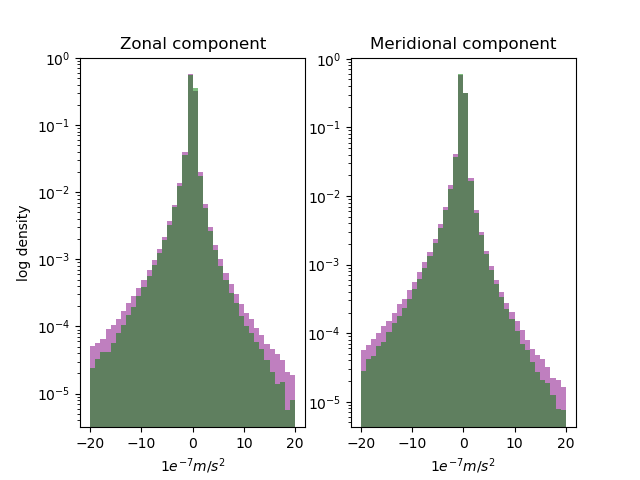

[########################################] | 100% Completed |  1min  7.1s
[########################################] | 100% Completed |  1min 28.1s
[########################################] | 100% Completed |  1min 15.9s
[########################################] | 100% Completed |  2min  9.6s


Text(0.5, 0, '$1e^{-7}m/s^2$')

In [14]:
%matplotlib notebook
bins = np.arange(-20, 21, 1)

assert np.all(np.isnan(data_['S_x']) == np.isnan(pred_stochastic['S_x'])), "Not the same number of points!"

plt.figure()
plt.subplot(121)
with ProgressBar():
    plt.hist(np.ravel(data_['S_x']), bins=bins, density=True, log=True, alpha=0.5, color='purple')
    plt.hist(np.ravel(pred_stochastic['S_x']), bins=bins, density=True, log=True, alpha=0.5, color='green')
plt.title('Zonal component')
plt.xlabel(r'$1e^{-7}m/s^2$')
plt.ylabel('log density')
plt.subplot(122)
with ProgressBar():
    plt.hist(np.ravel(data_['S_y']), bins=bins, density=True, log=True, alpha=0.5, color='purple')
    plt.hist(np.ravel(pred_stochastic['S_y']), bins=bins, density=True, log=True, alpha=0.5, color='green')
plt.title('Meridional component')
plt.xlabel(r'$1e^{-7}m/s^2$')


In [78]:
plt.savefig('forcing_dist_control.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
quantiles = np.exp(np.linspace(-3, 3, 100)) / (1 + np.exp(np.linspace(-3, 3, 100)))

with ProgressBar():
    q_true = np.nanquantile(data_['S_x'].values.ravel(), quantiles)
    q_sim = np.nanquantile(pred_stochastic['S_x'].values.ravel(), quantiles)

[########################################] | 100% Completed | 13.2s


/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


NameError: name 'pred_stochastic' is not defined

<IPython.core.display.Javascript object>


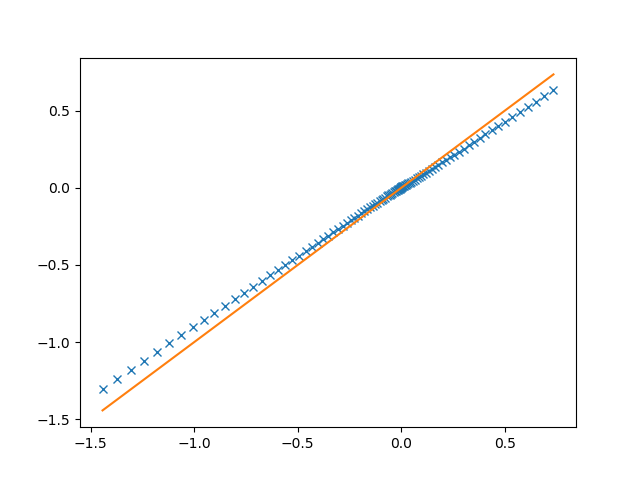

In [44]:
plt.figure()
plt.plot(q_true, q_sim, 'x')
plt.plot(q_true, q_true)

<IPython.core.display.Javascript object>


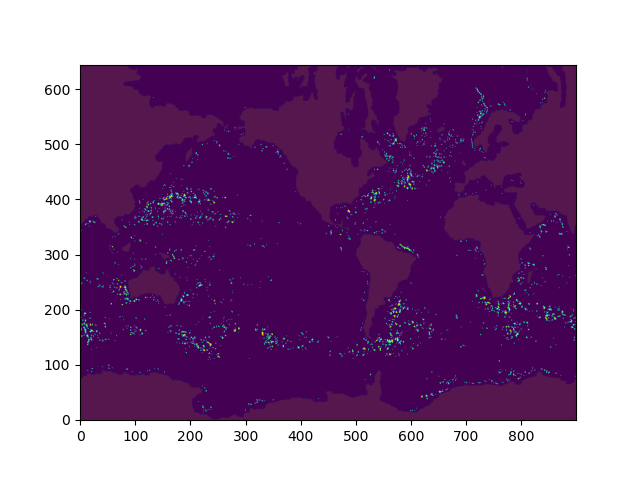

In [40]:
plt.figure()
plt.imshow(data['S_x'].isel(time=500) > 2, origin='lower')
plt.imshow(np.isnan(data['S_x'].isel(time=0)), origin='lower', alpha=0.1)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


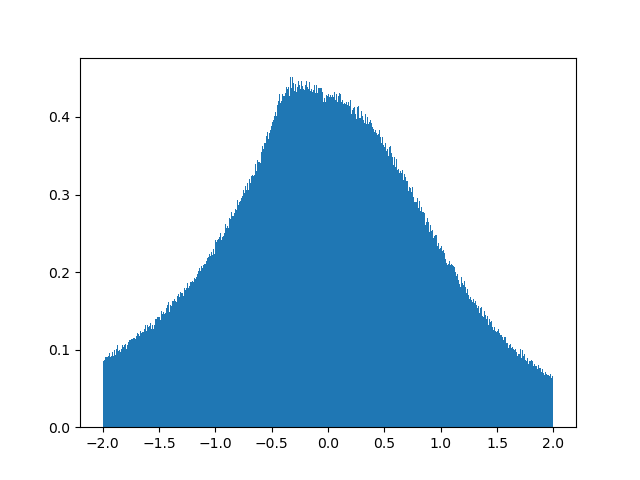

[########################################] | 100% Completed |  3min  0.3s


In [76]:
plt.figure()
with ProgressBar():
    plt.hist(np.ravel(residuals_x), bins=np.linspace(-2, 2, 1000), density=True)

<IPython.core.display.Javascript object>


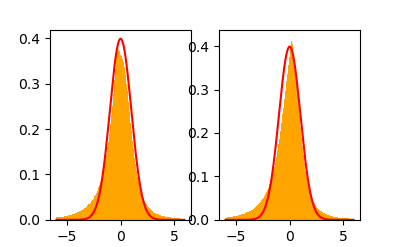

[########################################] | 100% Completed |  2min 43.9s
[########################################] | 100% Completed |  2min 40.3s


In [33]:
%matplotlib notebook
plt.figure()
bins=np.arange(-6, 6, 0.025)
from scipy.stats import norm
with ProgressBar():
    plt.subplot(121)
    plt.hist(np.ravel(residuals_x.compute()), bins=bins, density=True, color='orange')
    plt.plot(bins, (norm.pdf(bins)), 'r')
    plt.subplot(122)
    plt.hist(np.ravel(residuals_y.compute()), bins=bins, density=True, color='orange')
    plt.plot(bins, (norm.pdf(bins)), 'r')

In [ ]:
plt.legend()

In [34]:
plt.savefig('normalized_residuals_ditribution.jpg', dpi=300)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### QQ plot

In [71]:
quantiles = np.exp(np.linspace(-10, 10, 100)) / (1 + np.exp(np.linspace(-10, 10, 100)))
quantiles

array([4.53978687e-05, 5.55606489e-05, 6.79983174e-05, 8.32200197e-05,
       1.01848815e-04, 1.24647146e-04, 1.52547986e-04, 1.86692945e-04,
       2.28478855e-04, 2.79614739e-04, 3.42191434e-04, 4.18766684e-04,
       5.12469082e-04, 6.27124987e-04, 7.67413430e-04, 9.39055039e-04,
       1.14904229e-03, 1.40591988e-03, 1.72012560e-03, 2.10440443e-03,
       2.57431039e-03, 3.14881358e-03, 3.85103236e-03, 4.70911357e-03,
       5.75728612e-03, 7.03711536e-03, 8.59898661e-03, 1.05038445e-02,
       1.28252101e-02, 1.56514861e-02, 1.90885420e-02, 2.32625358e-02,
       2.83228820e-02, 3.44451957e-02, 4.18339400e-02, 5.07243606e-02,
       6.13831074e-02, 7.41067363e-02, 8.92170603e-02, 1.07052146e-01,
       1.27951705e-01, 1.52235823e-01, 1.80176593e-01, 2.11963334e-01,
       2.47663801e-01, 2.87185901e-01, 3.30246430e-01, 3.76354517e-01,
       4.24816868e-01, 4.74768924e-01, 5.25231076e-01, 5.75183132e-01,
       6.23645483e-01, 6.69753570e-01, 7.12814099e-01, 7.52336199e-01,
      

In [72]:
with ProgressBar():
    quantiles_x = np.nanquantile(residuals_x.compute(), quantiles)
    quantiles_y = np.nanquantile(residuals_y.compute(), quantiles)

[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 41.2s


In [73]:
from scipy.stats import norm, cauchy, t
quantiles_norm = norm.ppf(quantiles)
quantiles_cauchy = cauchy.ppf(quantiles)
student_3 = t(2)
quantiles_student = student_3.ppf(quantiles)

In [74]:
quantiles_x[int(len(quantiles)/2)]

0.10935827510235674

<IPython.core.display.Javascript object>


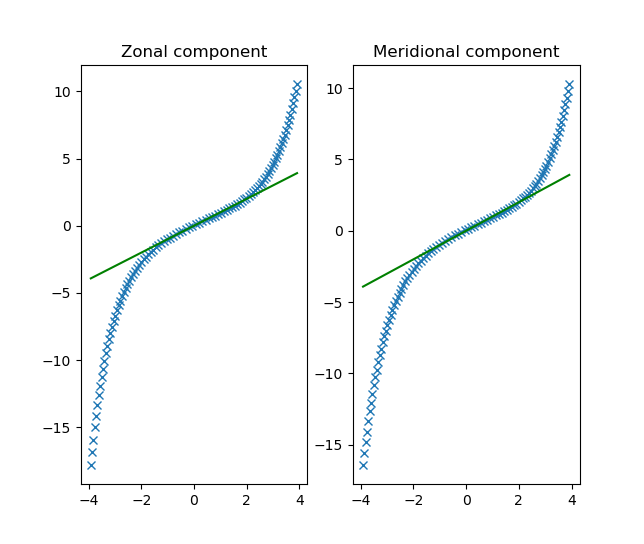

Text(0.5, 1.0, 'Meridional component')

In [75]:
plt.figure()
reference = quantiles_norm
plt.subplot(121)
plt.plot(reference, quantiles_x, 'x')
plt.plot(reference, reference, 'g')
plt.title('Zonal component')
plt.subplot(122)
plt.plot(reference, quantiles_y, 'x')
plt.plot(reference, reference, 'g')
plt.title('Meridional component')

In [32]:
plt.savefig('normalized_residuals_qq.jpg')

### Another way to do it

In [76]:
from scipy.stats import norm
lon = slice(None, None, 1)
lat= slice(-40, 40, 1)
time_slice = slice(None, 1000, 1)

true = apply_complete_mask(data['S_x'])
pred_mean = apply_complete_mask(pred['S_x'])
pred_std = apply_complete_mask(pred['S_xscale'])

def my_transform(x , mean, precision):
    cdf = lambda x: norm.cdf((x - mean) * precision) 
    return cdf(x)

v = xr.apply_ufunc(my_transform, true, pred_mean, 1 / pred_std,
                  dask='parallelized', output_dtypes=[np.float64, ])
residuals = (true - pred_mean) / pred_std
residuals = residuals.sel(longitude=lon, latitude=lat).isel(time=time_slice)
v = v.sel(longitude=lon, latitude=lat).isel(time=time_slice)

In [44]:
with ProgressBar():
    q2 = np.nanquantile(residuals, quantiles)

[########################################] | 100% Completed | 45.5s


<IPython.core.display.Javascript object>


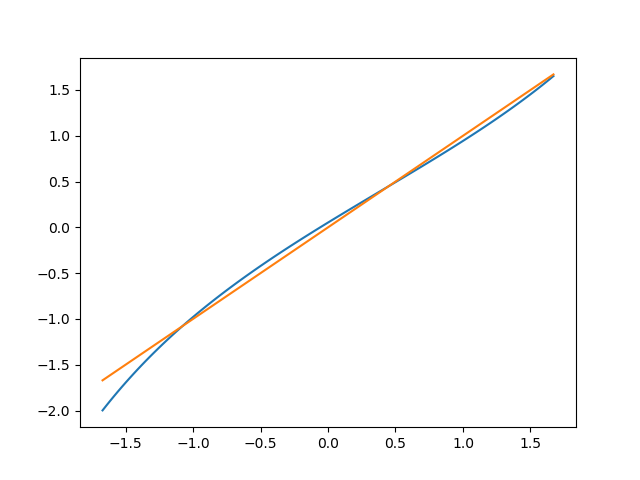

In [45]:
norm_quantiles = norm.ppf(quantiles)
plt.figure()
plt.plot(norm_quantiles, q2)
plt.plot(norm_quantiles, norm_quantiles)

<IPython.core.display.Javascript object>


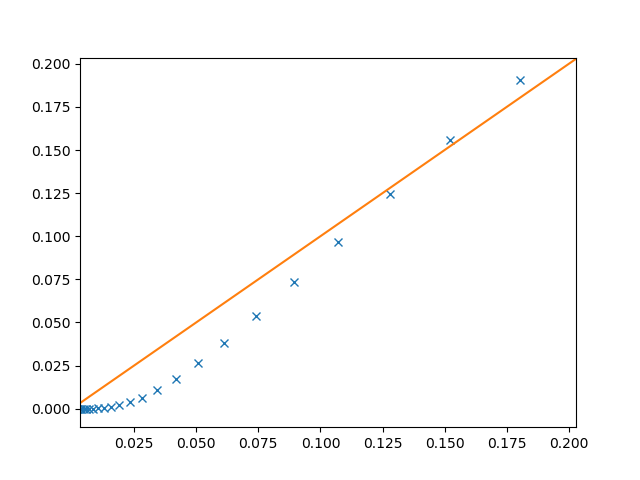

In [78]:
q = np.nanquantile(v, quantiles)


In [ ]:
plt.figure()
plt.plot(quantiles, q, 'x')
plt.plot(quantiles, quantiles)

## Likelihood plot

<IPython.core.display.Javascript object>


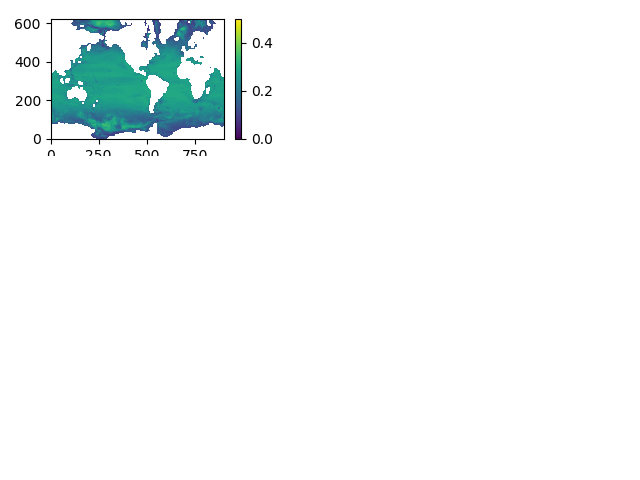

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [79]:
lon = slice(None, None, 1)
lat= slice(-80, 80, 1)
time_slice = slice(None, 1000, 1)

true = data['S_x']
pred_mean = pred['S_x']
pred_std = pred['S_xscale']

residuals = (true - pred_mean) / pred_std
lkh = xr.apply_ufunc(norm.pdf, residuals, dask='parallelized', output_dtypes=[np.float64,])
plt.figure()
plt.imshow(lkh.mean(dim='time'), origin='lower', vmin=0, vmax=0.5)
plt.colorbar()

In [81]:
lat= slice(-40, 40, 1)

with ProgressBar():
    lkh_mean = lkh.sel(latitude=lat).isel(time=time_slice).mean().compute()
lkh_mean

[########################################] | 100% Completed |  1min 30.7s


<xarray.DataArray ()>
array(0.27420494)

## Bias analysis

In [22]:
errors_x = pred['S_x'] - data['S_x']
map_errors_x = errors_x.mean(dim='time')
with ProgressBar():
    map_errors_x = map_errors_x.compute()
    std_forcing = (np.abs(data['S_x'])).std(dim='time').compute()

[########################################] | 100% Completed |  2min 21.3s
[                                        ] | 0% Completed |  0.1s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#                                       ] | 3% Completed |  4.4s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 15.8s


In [23]:
relative_bias = (map_errors_x / std_forcing).compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


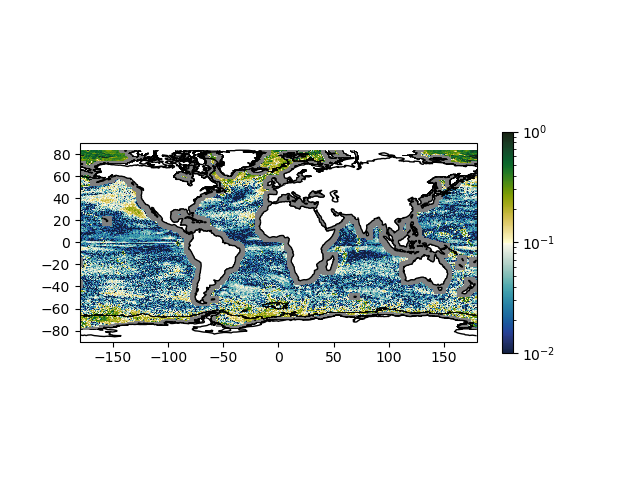

Using cached version!
Using cached version!
[########################################] | 100% Completed |  0.4s


In [24]:
import matplotlib
with ProgressBar():
    uv_plotter.plot(abs(relative_bias), cmap=cmocean.cm.delta, lon=0., vmin=0.01, vmax=1, norm=matplotlib.colors.LogNorm())

In [25]:
plt.savefig('relative_bias_control.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


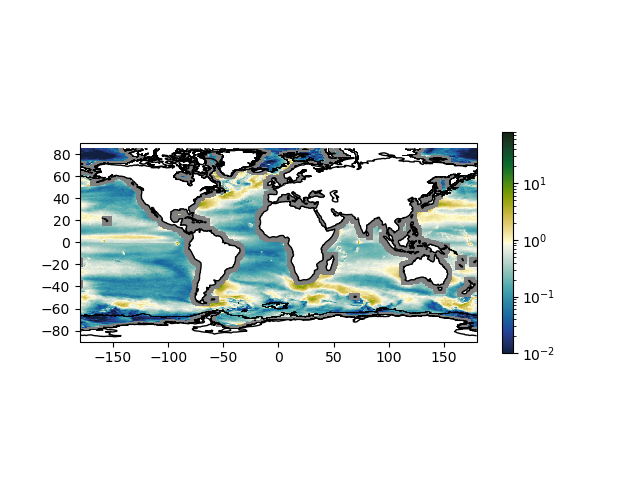

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [13]:
uv_plotter.plot(mean_abs, lon=0., cmap=cmocean.cm.delta, vmin=1e-2, norm=matplotlib.colors.LogNorm())

<IPython.core.display.Javascript object>


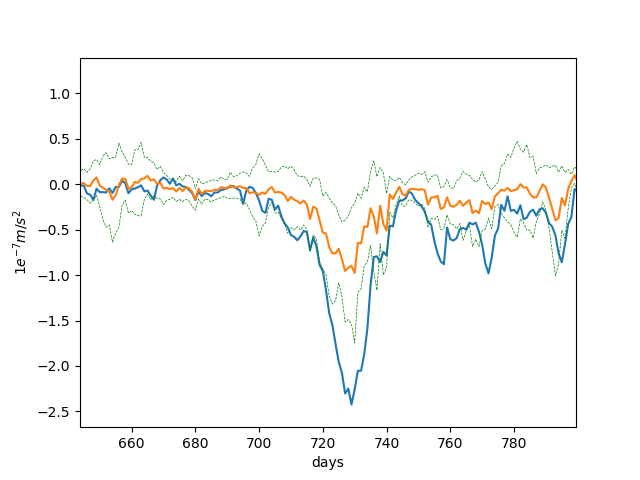

In [23]:
points = [(-42, 39), (-104, -20), (-129, 29)]

plot_time_series(*points[2], slice(0, 3900), std=True)


In [21]:
plt.savefig('timeseries_westcoast.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Comparison of quantiles

In [8]:
from analysis.base import QuantileCompare

with ProgressBar():
    qq = QuantileCompare()
    qq.quantiles = [0.25, 0.5, 0.75, 0.95]
    qq.data = ((pred['S_x']-data['S_x']) / pred['S_xscale']).isel(time=slice(None, None, 20)).compute()

[########################################] | 100% Completed |  2min 24.1s


In [17]:
with ProgressBar():
    q_0_75 = qq.data_quantiles[0.75]

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [ ]:
r = (pred['S_xpred']-data['S_x']) / pred['S_xscale']

In [ ]:
r = r.compute()

In [ ]:
q_0_5.median()

In [ ]:
r = (data['S_x'].sel(longitude=-130, latitude=30, method='nearest') - pred['S_xpred'].sel(longitude=-130, latitude=30, method='nearest'))/ pred['S_xscale'].sel(longitude=-130, latitude=30, method='nearest')

In [ ]:
r

In [ ]:
pred

In [ ]:
r = r.compute()

In [ ]:
plt.hist(r, bins = np.arange(-3, 3, 0.1))

In [ ]:
from dask import config

In [ ]:
config.set({'temporary-directory': '/scratch/ag7531/dasktemp'})

In [10]:
q_0_5 = q_0_5.compute()

In [11]:
q_0_5

<xarray.DataArray (latitude: 625, longitude: 900)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 -79.33 -79.17 -79.0 ... 82.84 83.01 83.18
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
    quantile   float64 0.5

In [12]:
uv_plotter = GlobalPlotter()

Using cached version!
Using cached version!


In [13]:
uv_plotter = GlobalPlotter()
uv_plotter.x_ticks = np.arange(-180, 181, 20)
uv_plotter.y_ticks = np.arange(-80, 81, 20)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cached version!
Using cached version!


/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


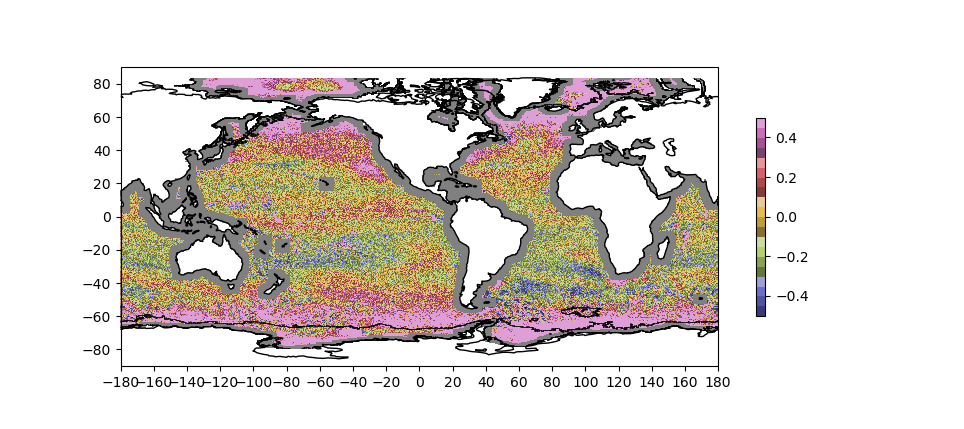

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [24]:
import cartopy.crs as ccrs
import cmocean
cmap = cmocean.cm.balance
uv_plotter.plot(q_0_75 - 0.67, vmin=-0.5, vmax=0.5, cmap='tab20b')

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


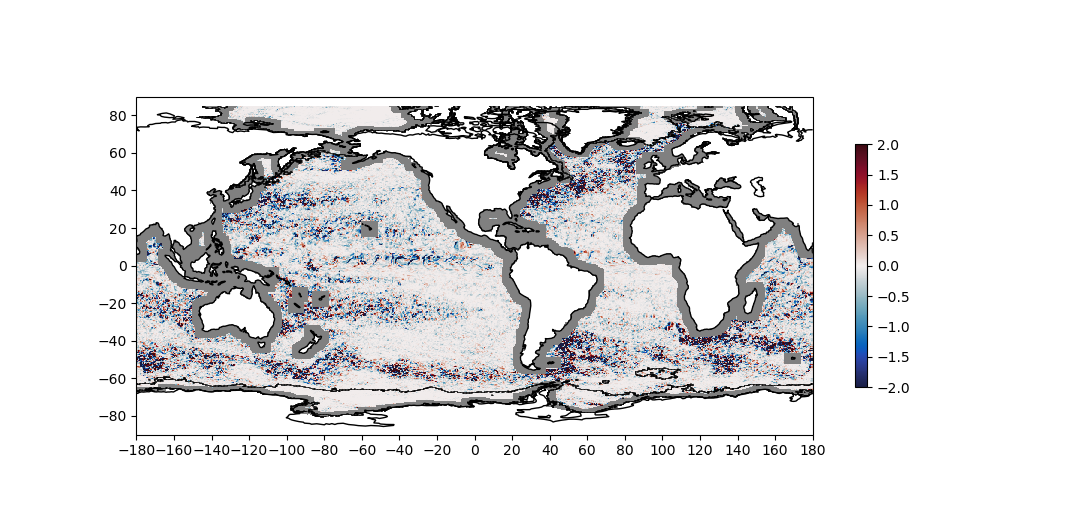

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [23]:
uv_plotter.plot(data['S_x'].isel(time=0), cmap=cmap_balance, vmin=-2, vmax=2)

In [ ]:
plt.plot((data['S_x'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data)
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data)
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)) + 1.96 * pred['S_xscale'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data, '--')
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)) - 1.96 * pred['S_xscale'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data, '--')


In [ ]:
r = qq.data.sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)).compute()

In [ ]:
np.quantile(r, [0.25, 0.5, 0.75])

In [ ]:
plt.hist(np.ravel(q_0_25.data), bins=np.arange(-2, 2, 0.1))
plt.title('Histogram of 0.25 quantiles of normalized residuals')

In [ ]:
np.quantile(r.data, [0.25, 0.5, 0.75])

In [ ]:
np.max(q_0_5).compute()

Snapshot of the forcing

In [ ]:
import cartopy.crs as ccrs
cmap = cmocean.cm.balance
s_x = v

ax = plt.axes(projection=ccrs.PlateCarree(-100.))
mesh_x, mesh_y = np.meshgrid(s_x['longitude'], s_x['latitude'])
mesh_x = mesh_x + 360
ax.pcolormesh(mesh_x, mesh_y, s_x.values, vmin=-4, vmax=4, transform = ccrs.PlateCarree(), cmap=cmap, alpha=1)
mesh_x, mesh_y = np.meshgrid(borders['longitude'], borders['latitude'])
mesh_x = mesh_x + 360
ax.pcolormesh(mesh_x, mesh_y, borders * 1., transform=ccrs.PlateCarree(), alpha=0.1)
ax.set_global()
ax.coastlines()
ax.set_xticks(np.arange(-180, 181, 20))
ax.set_yticks(np.arange(-80,81, 20))
#ax.set_extent([-20, 20, -20, 20])


In [ ]:
%matplotlib notebook

In [ ]:
from matplotlib import animation
cmap = cmocean.cm.amp
import cartopy.crs as ccrs

fig = plt.figure()

try:
    del video
except:
    pass

uv_plotter.x_ticks = None
uv_plotter.y_ticks = None

def animate(i):
    print(i)
    v = pred['S_xscale'].isel(time=i)
    uv_plotter.plot(v, projection_cls = ccrs.Orthographic, lon=(i/5)%360, cmap=cmap, vmin=0, vmax=2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, frames = 500, interval = 50)

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100

In [ ]:
ani.save('forcing_pred_mean.mp4', fps=60, dpi=300)

In [ ]:
from IPython.display import HTML
video = ani.to_html5_video()
HTML(video)

In [ ]:
e = (merged['S_xpred'] - merged['S_x']) / merged['S_xscale']
d = (e**2).mean(dim='time').compute()

In [ ]:
d_ = abs(d-1)
d_ = d_.interp(mask_.coords)
d_ = xr.where(borders, -1000, d_)
d_ = xr.where(mask__, d_, np.nan)
d_ = d_.interp(latitude = np.arange(-80, 80, 0.1), longitude = np.arange(-279.9, 80.1, 0.1))
d_['longitude'] = d_['longitude'] + 100.

ax = plt.axes(projection=ccrs.PlateCarree())
d_.plot.imshow(x='longitude', y='latitude', ax=ax, vmin=0, vmax=2, cmap=cmap,
                        transform = ccrs.PlateCarree(-100.))
ax.set_global()
ax.coastlines()
x_ticks = plt.xticks(np.arange(-180, 181, 20))
y_ticks = plt.yticks(np.arange(-80, 81, 20))